# A short analysis of the compressive strength of concrete. 
> Dataset from https://www.kaggle.com/datasets/sinamhd9/concrete-comprehensive-strength

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from timeit import default_timer as timer

import xml.etree.ElementTree as ET
from xml.dom import minidom
import os
import io
from datetime import datetime

In [103]:
%pip install xlwt

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [104]:
df = pd.read_excel('data/Concrete_Data.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

##### Save df.info() for documentation purposes

In [105]:
buffer = io.StringIO()
df.info(buf=buffer)
s = buffer.getvalue()

with open(os.path.join("./Metadata/", ("df_info.txt")), "w", encoding="utf-8") as f:  
    f.write(s)


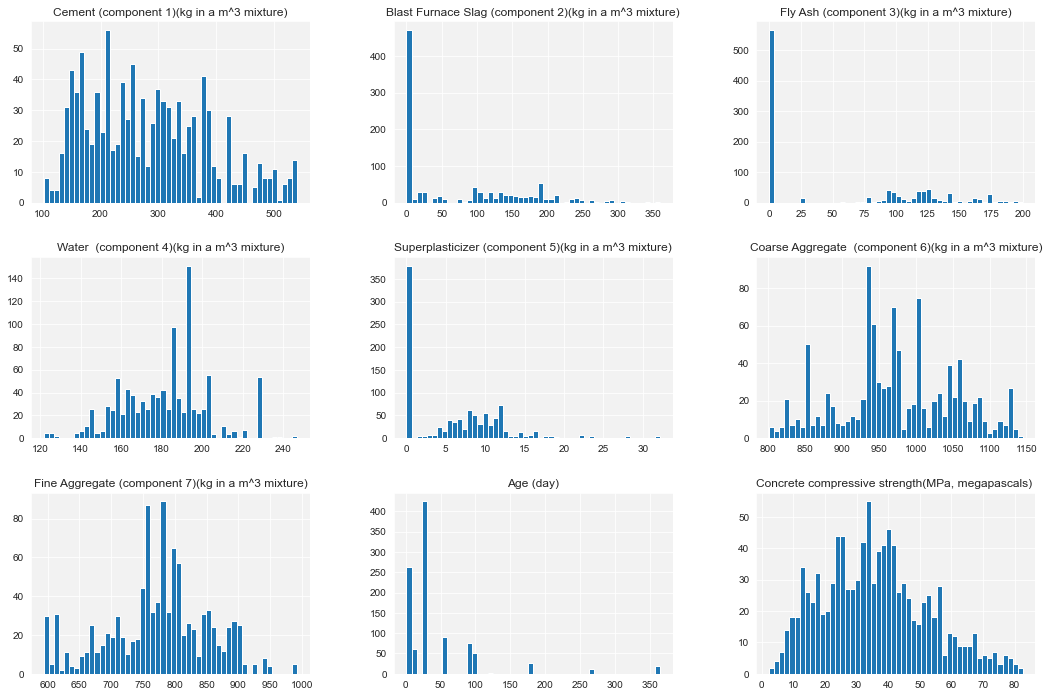

In [106]:
df.hist(bins=50, figsize=(18,12))
plt.show()

##### Transform column names for more ease of use

In [107]:
old_columns = df.columns

df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age', 'strength']

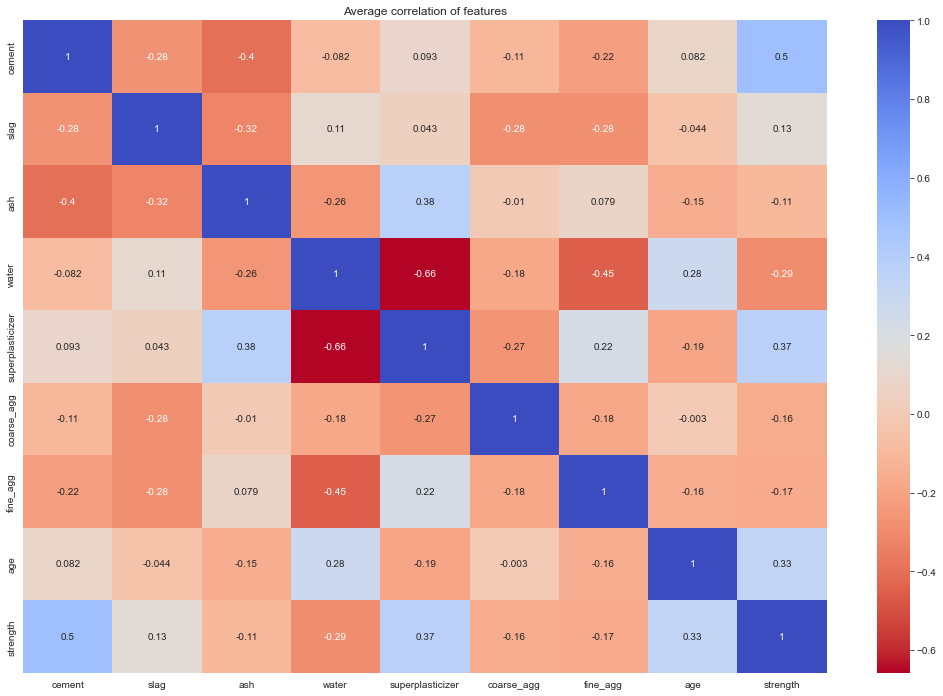

In [108]:
plt.figure(figsize=(18, 12))
plt.title('Average correlation of features')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm_r')
plt.show()

In [109]:
df.corr()['strength'].sort_values(ascending=False)

strength            1.000000
cement              0.497833
superplasticizer    0.366102
age                 0.328877
slag                0.134824
ash                -0.105753
coarse_agg         -0.164928
fine_agg           -0.167249
water              -0.289613
Name: strength, dtype: float64

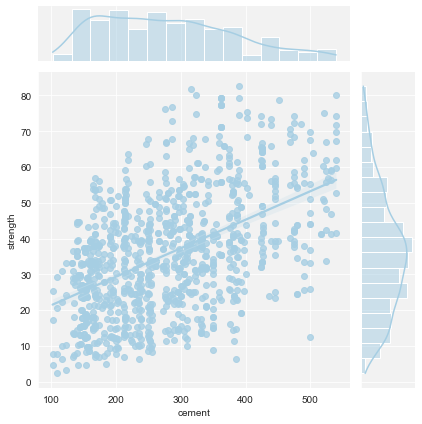

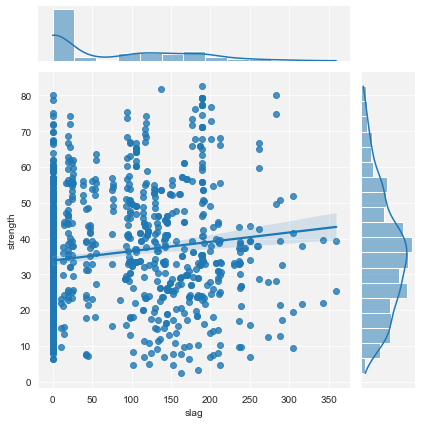

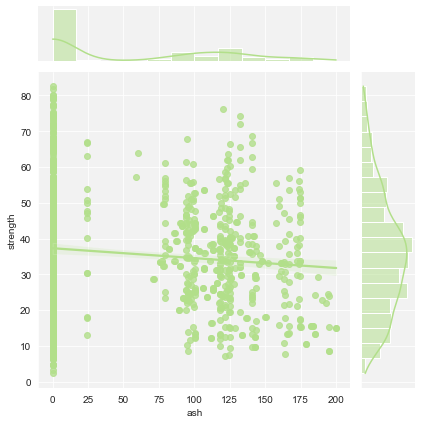

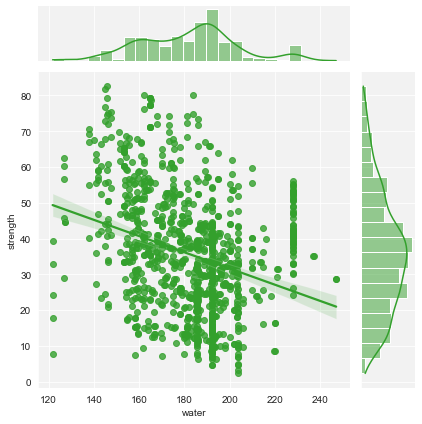

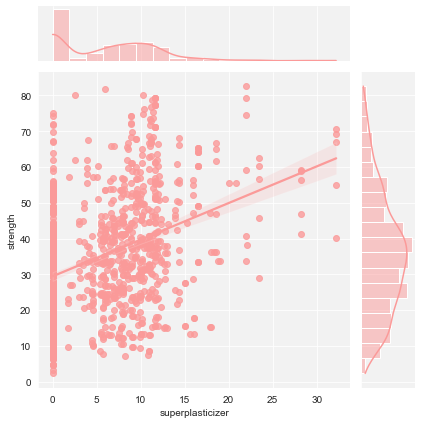

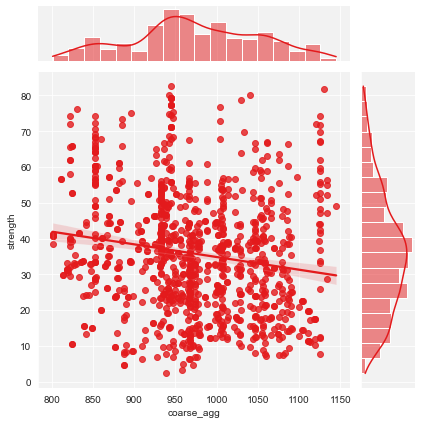

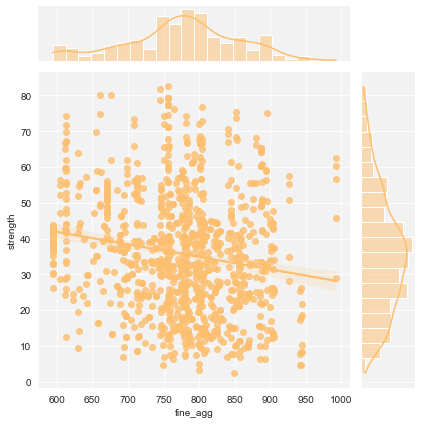

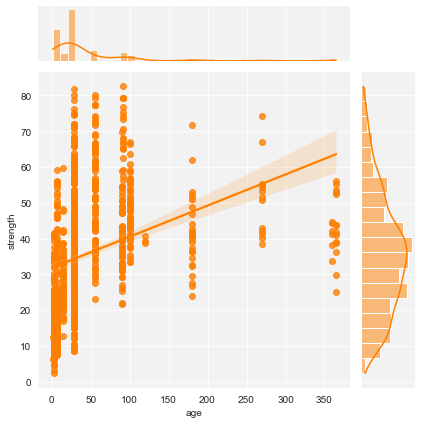

In [110]:
columns = df.columns.drop(['strength'])

for i in range(len(columns)):
    sns.jointplot(x=columns[i],
                  y='strength',
                  data=df,
                  kind='reg',
                  color=sns.color_palette("Paired", 8)[i])
    
plt.show()

#### Feature engineering

In [111]:
def calc_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [112]:
fe_df = df.copy()

fe_df['total'] = df.drop(['strength'], axis=1).sum(axis=1)

fe_df['cement_root'] = (fe_df['slag'] + fe_df['ash'] + fe_df['coarse_agg'] + fe_df['fine_agg']) / fe_df['total']	

fe_df['water_ratio'] = fe_df['water'] / fe_df['total']

fe_df['age_root'] = np.sqrt(fe_df['age'])

fe_df['super_used'] = df['superplasticizer'].map(lambda l: 1 if l > 0 else 0)

fe_df.head()

,cement,slag,ash,water,superplasticizer,coarse_agg,fine_agg,age,strength,total,cement_root,water_ratio,age_root,super_used
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111,2448.5,0.700837,0.066163,5.291503,1
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,2463.5,0.702659,0.065760,5.291503,1
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535,2499.0,0.667667,0.091236,16.431677,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780,2594.0,0.643215,0.087895,19.104973,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075,2686.9,0.720645,0.071458,18.973666,0


#### MI-Scores of the feature engineered and non feature engieered datasets

In [113]:
fe_X = fe_df.drop(['strength'], axis=1)
fe_y = fe_df['strength']

nofe_X = df.drop(['strength'], axis=1)
nofe_y = df['strength']

mi_scores = pd.DataFrame({'No FE': calc_mi_scores(nofe_X, nofe_y), 'FE': calc_mi_scores(fe_X, fe_y)})
mi_scores = mi_scores.sort_values(by='FE', ascending=False)
mi_scores

,No FE,FE
total,NaN,0.565855
water_ratio,NaN,0.443053
cement_root,NaN,0.430652
age_root,NaN,0.358832
water,0.363089,0.358788
age,0.361316,0.355542
cement,0.306563,0.309936
coarse_agg,0.250274,0.252517
superplasticizer,0.221127,0.220276
fine_agg,0.211632,0.215669


#### Model tester using cross-validation

In [114]:
def model_tester(df, models):
    results = {"ModelName" : [], "MeanCVScore" : [], "StdCVScore" : []}
    for i in range(len(models)):
        start = timer()
        
        X = df.drop('strength', axis=1)
        y = df['strength']
        scaler = StandardScaler()
        model = models[i]
        
        steps = [('scaler', scaler), ('regressor', model)]
        pipeline = Pipeline(steps)
        
        cv_results = cross_val_score(pipeline, X, y, cv=10)
        
        end = timer()
        
        print(f'{model.__class__.__name__} CV score: {cv_results.mean():.4f} +/- {cv_results.std():.4f} Time: {(end - start):.2f}s')
        
        results["ModelName"].append(model.__class__.__name__)
        results["MeanCVScore"].append(cv_results.mean())
        results["StdCVScore"].append(cv_results.std())
        
    return results

#### No feature engineering Linear Regression

In [115]:
X = df.drop('strength', axis=1)
y = df['strength']

model = LinearRegression()
scaler = StandardScaler()
steps = [('scaler', scaler), ('regressor', model)]
pipeline = Pipeline(steps)

cv_results = cross_val_score(pipeline, X, y, cv=5)
print(cv_results)
np.mean(cv_results)

[0.33082718 0.41188352 0.45161151 0.60710729 0.50391324]


0.46106854740704317

#### Testing different models on feature engineered data

LinearRegression CV score: 0.8312 +/- 0.0261 Time: 0.02s
Lasso CV score: 0.8220 +/- 0.0246 Time: 0.15s
Ridge CV score: 0.8315 +/- 0.0263 Time: 0.05s
XGBRegressor CV score: 0.9339 +/- 0.0360 Time: 11.55s
RandomForestRegressor CV score: 0.9105 +/- 0.0341 Time: 6.15s


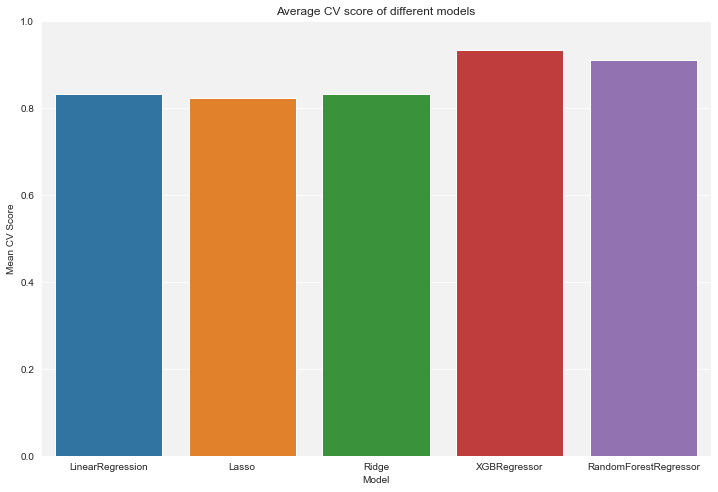

In [116]:
constant_state = 42

models = [LinearRegression(n_jobs=-1),
          Lasso(max_iter=1000, alpha=0.1, random_state=constant_state), 
          Ridge(alpha=0.05, random_state=constant_state),
          XGBRegressor(n_estimators=500, learning_rate=0.1, n_jobs=-1, random_state=constant_state),
          RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=constant_state),
          ]

# Shuffled as the dataset is in a weird order
results = model_tester(fe_df.sample(frac=1), models)

results_df = pd.DataFrame(results)


plt.figure(figsize=(12, 8))
plt.title('Average CV score of different models')
ax = sns.barplot(x='ModelName', y='MeanCVScore', data=results_df)
ax.set(xlabel='Model', ylabel='Mean CV Score', ylim=(0, 1))
plt.show()

#### Exporting feature engineered data

In [117]:
fe_df.to_excel('data/FE_Concrete_Data.xls', sheet_name='FE_Concrete_Data')
fe_df.to_csv('data/FE_Concrete_Data.csv')

#### Creating metadata for our data

In [118]:
def GenerateXML(filename="export", path="./Metadata/", metadata={"id": 1, "name": "test", "date": datetime.today().strftime('%d-%m-%Y')}):
    
    root = ET.Element("doc")
    
    for key in metadata.keys():
        entry = ET.SubElement(root, key)
        entry.text = str(metadata[key])
    
    xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
    
    with open (os.path.join(path, (filename + ".xml")), "wb") as f:
        print(f"XML generated at path: {path} as: {filename}.xml")
        f.write(xmlstr.encode('utf-8'))

In [120]:
my_metadata = {
    "id": 42,
    "name": "Ryland Grace",
    "institute": "HU Berlin",
    "date_published": datetime.today().strftime('%d-%m-%Y'),
    "PID": "123-456-789"
}

GenerateXML(metadata=my_metadata)

XML generated at path: ./Metadata/ as: export.xml
